In [4]:
import keras
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from keras import models, layers, optimizers, regularizers

In [5]:
df = pd.read_csv('listings2.csv')
df = df.rename(columns={'neighbourhood_group_cleansed':'neighbourhood_group'})

## Let's get an overview of the data

In [6]:
print(df.columns)
nulls = df.isna().sum()
print(nulls)

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url',
       'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'square_fe

In [31]:
df

,host_response_time,host_response_rate,host_has_profile_pic,neighbourhood_group,zipcode,market,smart_location,latitude,longitude,is_location_exact,...,has_availability,availability_90,number_of_reviews,first_review,last_review,requires_license,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification
0,within a few hours,96%,t,Queen Anne,98119,Seattle,"Seattle, WA",47.636289,-122.371025,t,...,t,71,207,2011-11-01,2016-01-02,f,f,moderate,f,f
1,within an hour,98%,t,Queen Anne,98119,Seattle,"Seattle, WA",47.639123,-122.365666,t,...,t,16,43,2013-08-19,2015-12-29,f,f,strict,t,t
2,within a few hours,67%,t,Queen Anne,98119,Seattle,"Seattle, WA",47.629724,-122.369483,t,...,t,17,20,2014-07-30,2015-09-03,f,f,strict,f,f
3,NaN,NaN,t,Queen Anne,98119,Seattle,"Seattle, WA",47.638473,-122.369279,t,...,t,0,0,NaN,NaN,f,f,flexible,f,f
4,within an hour,100%,t,Queen Anne,98119,Seattle,"Seattle, WA",47.632918,-122.372471,t,...,t,90,38,2012-07-10,2015-10-24,f,f,strict,f,f
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3813,within a few hours,99%,t,Other neighborhoods,98107,Seattle,"Seattle, WA",47.664295,-122.359170,t,...,t,32,1,2015-09-27,2015-09-27,f,f,strict,f,f
3814,within an hour,100%,t,Capitol Hill,98102,Seattle,"Seattle, WA",47.649552,-122.318309,t,...,t,44,2,2015-12-18,2015-12-24,f,f,moderate,f,f
3815,NaN,NaN,t,Rainier Valley,98178,Seattle,"Seattle, WA",47.508453,-122.240607,f,...,t,88,0,NaN,NaN,f,f,moderate,f,f
3816,within an hour,100%,t,Capitol Hill,98112,Seattle,"Seattle, WA",47.632335,-122.275530,f,...,t,90,0,NaN,NaN,f,f,moderate,f,f


### After doing some research, I found that the best features to use are categorical and numerical so we'll drop text columns 

In [7]:
text_cols_to_drop = ['listing_url', 'scrape_id',
                'last_scraped', 'name', 'summary', 'space',
                'description', 'neighborhood_overview', 'notes', 'transit',
                'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_id', 'host_url', 'host_name',
                'host_location', 'host_about', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
                'host_verifications',
                'calendar_last_scraped', 'amenities']
df = df.drop(text_cols_to_drop, axis=1, inplace=False)

## We'll also get rid of the columns that contain too many nan's

In [8]:
df = df.drop(['host_acceptance_rate',
         'square_feet', 'weekly_price', 'monthly_price', 'license',
         'jurisdiction_names', 'experiences_offered'], axis=1, inplace=False)

## Some columns also contain mostly the same data so we can drop those

In [9]:
print(sum((df.host_listings_count == df.host_total_listings_count) == False))

2


In [10]:
df.drop(['host_total_listings_count', 'calculated_host_listings_count'],
        axis=1, inplace=True)

### For nans in bathrooms, bedrooms, and beds, they can be replaced with the median

In [11]:
for col in ['bathrooms', 'bedrooms', 'beds']:
    df[col].fillna(df[col].median(), inplace=True)

### Price features contain dollar signs and decimals which will be converted to int64s

In [12]:
df.price = df.price.str[1:-3]
df.price = df.price.str.replace(",", "")
df.price = df.price.astype('int64')

df.extra_people = df.extra_people.str[1:-3]
df.extra_people = df.extra_people.str.replace(",", "")
df.extra_people = df.extra_people.astype('int64')

### For availability 30, 60, 90, and 365, we'll get rid of all but one since including all of them won't help the model

In [13]:
df = df.drop(['availability_30', 'availability_60', 'availability_365'], axis=1)

### Since reviews per month is too correlated with number of reviews, we can delete it

In [14]:
df = df.drop(['reviews_per_month'], axis=1, inplace=False)

### Since many listings don't have reviews yet, we can drop review score features

In [15]:
df = df.drop(['review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
              'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value'], axis=1)

In [16]:
# Quick Check
print(df.isna().sum())

id                                     0
host_since                             2
host_response_time                   523
host_response_rate                   523
host_is_superhost                      2
host_listings_count                    2
host_has_profile_pic                   2
host_identity_verified                 2
street                                 0
neighbourhood                        416
neighbourhood_cleansed                 0
neighbourhood_group                    0
city                                   0
state                                  0
zipcode                                7
market                                 0
smart_location                         0
country_code                           0
country                                0
latitude                               0
longitude                              0
is_location_exact                      0
property_type                          1
room_type                              0
accommodates    

### Finally, we can drop the last columns with nan's and we drop other columns that aren't useful for testing

In [17]:
useless = ['id', 'host_is_superhost', 'host_since', 'host_listings_count', 'host_identity_verified', 'city', 'state',
           'country_code', 'neighbourhood', 'neighbourhood_cleansed', 'security_deposit', 'cleaning_fee',
           'street', 'country']
df = df.drop(useless, axis=1)

In [18]:
print(df.columns)

Index(['host_response_time', 'host_response_rate', 'host_has_profile_pic',
       'neighbourhood_group', 'zipcode', 'market', 'smart_location',
       'latitude', 'longitude', 'is_location_exact', 'property_type',
       'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds',
       'bed_type', 'price', 'guests_included', 'extra_people',
       'minimum_nights', 'maximum_nights', 'calendar_updated',
       'has_availability', 'availability_90', 'number_of_reviews',
       'first_review', 'last_review', 'requires_license', 'instant_bookable',
       'cancellation_policy', 'require_guest_profile_picture',
       'require_guest_phone_verification'],
      dtype='object')


### Since many property types are basically the same, we can also change those

In [19]:
print(df.property_type.value_counts())

House              1733
Apartment          1708
Townhouse           118
Condominium          91
Loft                 40
Bed & Breakfast      37
Other                22
Cabin                21
Bungalow             13
Camper/RV            13
Boat                  8
Tent                  5
Treehouse             3
Chalet                2
Dorm                  2
Yurt                  1
Name: property_type, dtype: int64


In [20]:
df['property_type'] = df.property_type.replace({
    'Townhouse': 'House',
    'Bungalow': 'House',
    'Loft': 'Apartment',
    'Chalet': 'Cabin'})

### Checking feature uniqueness

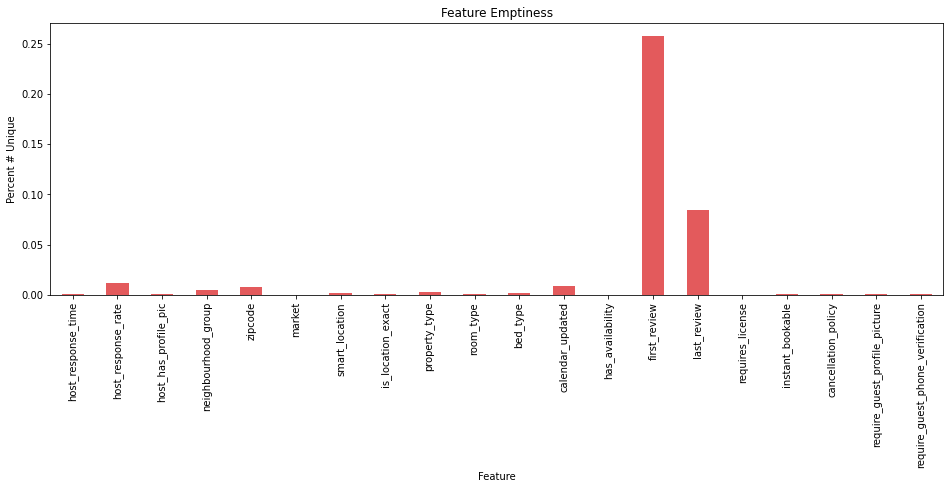

In [21]:
categories = df.columns[df.dtypes == 'object']
percentage_unique = df[categories].nunique() / df.shape[0]
ax = percentage_unique.plot(kind = 'bar', color='#E35A5C', figsize = (16, 5))
ax.set_xlabel('Feature')
ax.set_ylabel('Percent # Unique')
ax.set_title('Feature Emptiness')
plt.show()

### We can now encode categorical variables and log transform numerical variables

In [22]:
transformed_df = pd.get_dummies(df)
to_drop = ['beds',
           'bedrooms',
           'guests_included',
           'room_type_Private room']

numerical_columns = ['accommodates', 'availability_90', 'bathrooms', 'extra_people',
                     'host_days_active', 'maximum_nights', 'minimum_nights', 'number_of_reviews',
                     'price']

numerical_columns = [i for i in numerical_columns if i not in ['availability_90', 'host_days_active']]

for col in numerical_columns:
    transformed_df[col] = transformed_df[col].astype('float64').replace(0.0, 0.01) # Replacing 0s with 0.01 because log(0) undefined
    transformed_df[col] = np.log(transformed_df[col])

### Random Forest and a few other models will be tested first

In [23]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
X = transformed_df.drop('price', axis=1)
y = transformed_df.price

# Scaling
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=list(X.columns))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)    # random state 0 means results will less reproducible

In [24]:
# Defining a function so testing multiple models is easier
def ModelResults(classifier):
    classifier.fit(X_train, y_train)
    train_predict = classifier.predict(X_train)
    test_predict = classifier.predict(X_test)
    print("\nR^2 Train:", r2_score(y_train, train_predict))
    print("R^2 Test:", r2_score(y_test, test_predict))
    
ETR = ExtraTreesRegressor(max_depth=17, n_estimators=100, n_jobs=-1)
RFR = RandomForestRegressor(max_depth=17, n_estimators=100, n_jobs=-1)
GBR = GradientBoostingRegressor(n_estimators=200, learning_rate=0.2)
ModelResults(ETR)
ModelResults(RFR)
ModelResults(GBR)


R^2 Train: 0.9443155733321421
R^2 Test: 0.7267175467639235

R^2 Train: 0.9355009795814776
R^2 Test: 0.7494563992404082

R^2 Train: 0.8367358296539735
R^2 Test: 0.7453411112704833


Random Forest outperformed the other models on the validation set

### After significant trial and error, these are the two best models that I have found:
1. The first model uses an input layer of 128 and has two hidden layers with a size of 256 and 512 respectively.
2. The second model uses an input layer of size 128 and two hidden layers with a size of 256.

From my testing, I found that increasing the size and number of hidden layers only leads to overfitting. It was best to work with a small number of layers and sizes. I also found that Adam was the most reliable optimizer as compared to SGD which didn't perform well when I tested it on a San Francisco dataset.

In [25]:
def nn_model_evaluation(model, skip_epochs=0, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test):
    y_test_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)
    print("Training MSE:", round(mean_squared_error(y_train, y_train_pred),4))
    print("Validation MSE:", round(mean_squared_error(y_test, y_test_pred),4))
    print("\nTraining r2:", round(r2_score(y_train, y_train_pred),4))
    print("Validation r2:", round(r2_score(y_test, y_test_pred),4))

In [29]:
nn1 = models.Sequential()
nn1.add(layers.Dense(128, input_shape=(X_train.shape[1],), kernel_regularizer=regularizers.l1(0.02), activation='relu'))
nn1.add(layers.Dense(256, kernel_regularizer=regularizers.l1(0.02), activation='relu'))
nn1.add(layers.Dense(512, kernel_regularizer=regularizers.l1(0.02), activation='relu'))
nn1.add(layers.Dense(1, activation='relu'))

# Compiling the model
nn1.compile(loss='mean_squared_error',
            optimizer='adam',
            metrics=['mean_squared_error'])

nn1_history = nn1.fit(X_train,
                  y_train,
                  epochs=90,
                  batch_size=256,
                  validation_split = 0.1)

nn_model_evaluation(nn4)

Train on 2748 samples, validate on 306 samples
Epoch 1/90
2748/2748 [==============================] - 1s 373us/step - loss: 256.3477 - mean_squared_error: 7.1651 - val_loss: 223.6384 - val_mean_squared_error: 4.4993
Epoch 2/90
2748/2748 [==============================] - 0s 163us/step - loss: 200.9213 - mean_squared_error: 3.9549 - val_loss: 173.2456 - val_mean_squared_error: 2.7025
Epoch 3/90
2748/2748 [==============================] - 0s 144us/step - loss: 153.8086 - mean_squared_error: 2.4243 - val_loss: 130.9612 - val_mean_squared_error: 2.2939
Epoch 4/90
2748/2748 [==============================] - 0s 135us/step - loss: 114.5716 - mean_squared_error: 1.5209 - val_loss: 96.4820 - val_mean_squared_error: 1.5315
Epoch 5/90
2748/2748 [==============================] - 0s 143us/step - loss: 83.6130 - mean_squared_error: 0.7741 - val_loss: 70.4892 - val_mean_squared_error: 1.2955
Epoch 6/90
2748/2748 [==============================] - 0s 143us/step - loss: 61.1278 - mean_squared_error

Epoch 50/90
2748/2748 [==============================] - 0s 133us/step - loss: 1.0527 - mean_squared_error: 0.1334 - val_loss: 1.0337 - val_mean_squared_error: 0.1114
Epoch 51/90
2748/2748 [==============================] - 0s 134us/step - loss: 1.0482 - mean_squared_error: 0.1316 - val_loss: 1.0205 - val_mean_squared_error: 0.1107
Epoch 52/90
2748/2748 [==============================] - 0s 131us/step - loss: 1.0464 - mean_squared_error: 0.1303 - val_loss: 1.0280 - val_mean_squared_error: 0.1108
Epoch 53/90
2748/2748 [==============================] - 0s 134us/step - loss: 1.0417 - mean_squared_error: 0.1299 - val_loss: 1.0182 - val_mean_squared_error: 0.1100
Epoch 54/90
2748/2748 [==============================] - 0s 137us/step - loss: 1.0370 - mean_squared_error: 0.1292 - val_loss: 1.0231 - val_mean_squared_error: 0.1090
Epoch 55/90
2748/2748 [==============================] - 0s 131us/step - loss: 1.0402 - mean_squared_error: 0.1279 - val_loss: 1.0165 - val_mean_squared_error: 0.108

In [30]:
nn2 = models.Sequential()
nn2.add(layers.Dense(128, input_shape=(X_train.shape[1],), kernel_regularizer=regularizers.l1(0.02), activation='relu'))
nn2.add(layers.Dense(256, kernel_regularizer=regularizers.l1(0.02), activation='relu'))
nn2.add(layers.Dense(256, kernel_regularizer=regularizers.l1(0.02), activation='relu'))
nn2.add(layers.Dense(1, activation='relu'))

# Compiling the model
nn2.compile(loss='mean_squared_error',
            optimizer='adam',
            metrics=['mean_squared_error'])

nn2_history = nn2.fit(X_train,
                  y_train,
                  epochs=100,
                  batch_size=256,
                  validation_split = 0.1)

nn_model_evaluation(nn2)

Train on 2748 samples, validate on 306 samples
Epoch 1/100
2748/2748 [==============================] - 1s 370us/step - loss: 216.0875 - mean_squared_error: 9.9010 - val_loss: 187.5710 - val_mean_squared_error: 6.1201
Epoch 2/100
2748/2748 [==============================] - 0s 134us/step - loss: 167.7126 - mean_squared_error: 4.2876 - val_loss: 146.0644 - val_mean_squared_error: 3.9920
Epoch 3/100
2748/2748 [==============================] - 0s 133us/step - loss: 129.9539 - mean_squared_error: 2.7875 - val_loss: 111.2852 - val_mean_squared_error: 1.7980
Epoch 4/100
2748/2748 [==============================] - 0s 126us/step - loss: 98.7787 - mean_squared_error: 1.6514 - val_loss: 84.8323 - val_mean_squared_error: 1.9232
Epoch 5/100
2748/2748 [==============================] - 0s 124us/step - loss: 74.5716 - mean_squared_error: 0.9077 - val_loss: 64.5340 - val_mean_squared_error: 1.3010
Epoch 6/100
2748/2748 [==============================] - 0s 133us/step - loss: 57.1480 - mean_squared_

2748/2748 [==============================] - 0s 129us/step - loss: 0.8920 - mean_squared_error: 0.1361 - val_loss: 0.8664 - val_mean_squared_error: 0.1123
Epoch 50/100
2748/2748 [==============================] - 0s 117us/step - loss: 0.8881 - mean_squared_error: 0.1343 - val_loss: 0.8637 - val_mean_squared_error: 0.1123
Epoch 51/100
2748/2748 [==============================] - 0s 127us/step - loss: 0.8850 - mean_squared_error: 0.1339 - val_loss: 0.8588 - val_mean_squared_error: 0.1119
Epoch 52/100
2748/2748 [==============================] - 0s 125us/step - loss: 0.8771 - mean_squared_error: 0.1329 - val_loss: 0.8545 - val_mean_squared_error: 0.1122
Epoch 53/100
2748/2748 [==============================] - 0s 123us/step - loss: 0.8737 - mean_squared_error: 0.1330 - val_loss: 0.8532 - val_mean_squared_error: 0.1115
Epoch 54/100
2748/2748 [==============================] - 0s 121us/step - loss: 0.8714 - mean_squared_error: 0.1323 - val_loss: 0.8476 - val_mean_squared_error: 0.1113
Epoch

Epoch 98/100
2748/2748 [==============================] - 0s 127us/step - loss: 0.8326 - mean_squared_error: 0.0971 - val_loss: 0.8283 - val_mean_squared_error: 0.0944
Epoch 99/100
2748/2748 [==============================] - 0s 119us/step - loss: 0.8315 - mean_squared_error: 0.0972 - val_loss: 0.8306 - val_mean_squared_error: 0.0968
Epoch 100/100
2748/2748 [==============================] - 0s 119us/step - loss: 0.8323 - mean_squared_error: 0.0979 - val_loss: 0.8296 - val_mean_squared_error: 0.0940
Training MSE: 0.0907
Validation MSE: 0.0931

Training r2: 0.7147
Validation r2: 0.7149
